## C - Linear regression with Swyft

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 15 September 2023

**Purpose**: A first non-trivial example with vector-shaped data.

**Key take-away messages**: Low-dimensional linear regression tasks can be performed with standard Swyft functionality and networks.

### Code

In [1]:
import numpy as np
import pylab as plt
import torch
import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [2]:
DEVICE

'cpu'

In [3]:
torch.manual_seed(0)
np.random.seed(0)

We now consider a simple linear regression problem. Our data vector $\mathbf x$ has now length 100, and we consider three model parameters $\mathbf z$ which for the constant, linear and quatractic contribution.

$$ 
x_i = z[0] + z[1]\cdot y_i + z[2] \cdot y_i^2
$$

where $\mathbf y$ is a linear grid.

In [4]:
N = 10_000  # Number of samples
Nbins = 100
z = np.random.rand(N, 3)*2 - 1
y = np.linspace(-1, 1, Nbins)
m = np.ones_like(y)*z[:,:1] + y*z[:,1:2] + y**2*z[:,2:]
x = m + np.random.randn(N, Nbins)*0.2

# We keep the first sample as observation, and use the rest for training
samples = swyft.Samples(x = x[1:], z = z[1:])
obs = swyft.Sample(x = x[0], z = z[0])

In [5]:
obs

Sample({'x': array([-0.12304413,  0.19844972, -0.04719028, -0.20195   ,  0.03416797,
       -0.11692992,  0.0201929 , -0.4730634 , -0.39761317, -0.27231195,
       -0.56635344, -0.35267316,  0.09854852, -0.04260886, -0.24312582,
       -0.50810047, -0.18359462, -0.00572001, -0.06823005, -0.30052103,
       -0.16967097,  0.13703912, -0.03766382,  0.08588522, -0.1281288 ,
       -0.09857069,  0.05903534, -0.31100918,  0.19419486,  0.15144855,
       -0.01550598,  0.20485181, -0.0971566 , -0.15110056,  0.13578647,
        0.29792155, -0.20458907,  0.02482173, -0.20610093, -0.29265756,
       -0.13240723, -0.16669776,  0.24132664,  0.195801  ,  0.26282663,
        0.11091242,  0.00596427,  0.43507488, -0.15801129,  0.51223868,
        0.10018583,  0.23980878, -0.03200131,  0.10198628,  0.15166474,
       -0.06522187,  0.32143503,  0.0957977 ,  0.26702847,  0.35601878,
        0.31203207, -0.08762613,  0.06563112,  0.07452179,  0.05708632,
        0.40406603,  0.01613674,  0.39649896,  0.05

It is useful to visualize a subset of the training data, as well as our mock observation for which we will perform parameter inference below.

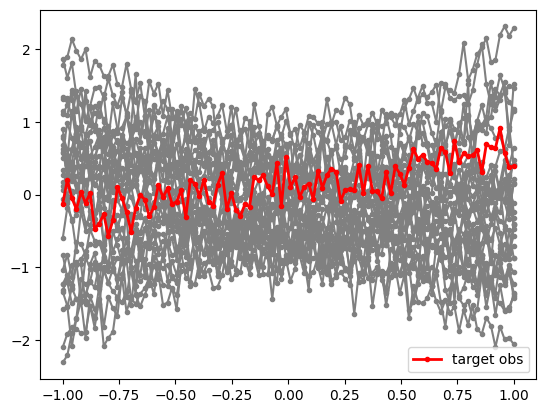

In [6]:
for i in range(30):
    plt.plot(y, samples[i]['x'], marker='.', color='0.5')
plt.plot(y, obs['x'], marker='.', color='r', lw = 2, label = 'target obs')
plt.legend(loc=0)

In [15]:
samples['x'].shape

(9999, 100)

In [16]:
samples['z'].shape

(9999, 3)

In [7]:
samples

Samples({'x': array([[ 0.62014954,  0.24623441,  0.4070549 , ...,  0.21176075,
         0.23836499, -0.23500184],
       [ 0.27372359,  0.17690092,  0.04395399, ...,  1.39286479,
         1.27762543,  1.17283785],
       [-1.03780782, -0.82672296, -1.13248747, ...,  0.39355914,
         0.13320587,  0.4684875 ],
       ...,
       [ 0.05467494, -0.3645885 , -0.20776758, ...,  1.58098113,
         1.53020312,  1.51915153],
       [ 0.32846357,  0.42122177,  0.40895631, ...,  0.75085117,
         1.0325496 ,  0.94159955],
       [ 0.33259771,  0.48244562,  0.45721899, ...,  1.25414449,
         1.52634082,  1.41069784]]), 'z': array([[ 0.08976637, -0.1526904 ,  0.29178823],
       [-0.12482558,  0.783546  ,  0.92732552],
       [-0.23311696,  0.58345008,  0.05778984],
       ...,
       [ 0.52798597,  0.77322147,  0.07037919],
       [ 0.64065597,  0.24471839,  0.06228088],
       [ 0.70580838,  0.46845911,  0.27799483]])})

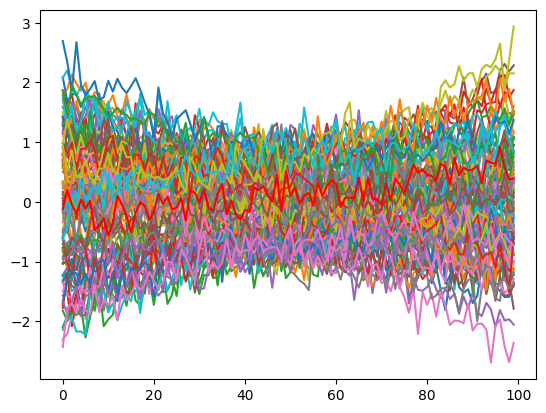

In [17]:
for i in range(min(len(samples),100)):
    plt.plot(samples[i]['x'])
plt.plot(obs['x'], color='r')

In [8]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = Nbins, num_params = 3, varnames = 'z')

    def forward(self, A, B):
        return self.logratios(A['x'], B['z'])

trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64)
dm = swyft.SwyftDataModule(samples)
network = Network()
trainer.fit(network, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following cal

Sanity Checking: 0it [00:00, ?it/s]

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /home/gert/ALPs_with_SWYFT/notebooks/lightning_logs/version_22/checkpoints/epoch=4-step=1250.ckpt


Inference is done as before, now targeting the mock observation from above. We plot the three one-dimensional posteriors side by side.

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


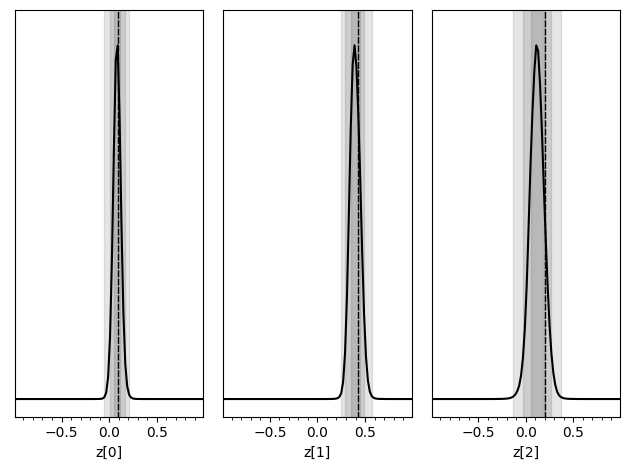

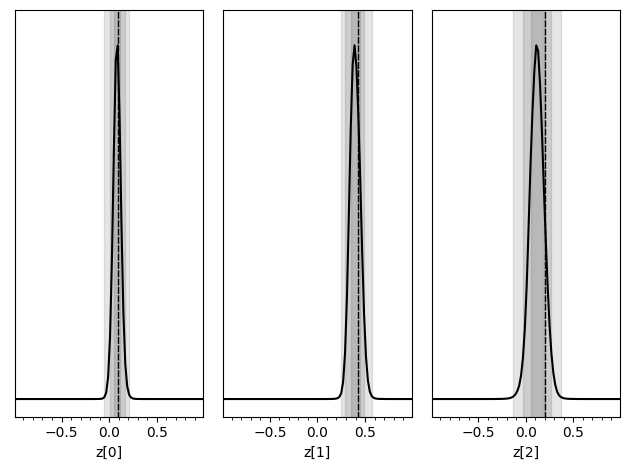

In [9]:
prior_samples = swyft.Samples(z = np.random.rand(100_000, 3)*2-1)
predictions = trainer.infer(network, obs, prior_samples)

truth = {k: v for k, v in zip(["z[%i]"%i for i in range(3)], obs['z'])}
swyft.plot_posterior(predictions, ["z[%i]"%i for i in range(3)], truth=truth)

In [20]:
obs

Sample({'x': array([-0.12304413,  0.19844972, -0.04719028, -0.20195   ,  0.03416797,
       -0.11692992,  0.0201929 , -0.4730634 , -0.39761317, -0.27231195,
       -0.56635344, -0.35267316,  0.09854852, -0.04260886, -0.24312582,
       -0.50810047, -0.18359462, -0.00572001, -0.06823005, -0.30052103,
       -0.16967097,  0.13703912, -0.03766382,  0.08588522, -0.1281288 ,
       -0.09857069,  0.05903534, -0.31100918,  0.19419486,  0.15144855,
       -0.01550598,  0.20485181, -0.0971566 , -0.15110056,  0.13578647,
        0.29792155, -0.20458907,  0.02482173, -0.20610093, -0.29265756,
       -0.13240723, -0.16669776,  0.24132664,  0.195801  ,  0.26282663,
        0.11091242,  0.00596427,  0.43507488, -0.15801129,  0.51223868,
        0.10018583,  0.23980878, -0.03200131,  0.10198628,  0.15166474,
       -0.06522187,  0.32143503,  0.0957977 ,  0.26702847,  0.35601878,
        0.31203207, -0.08762613,  0.06563112,  0.07452179,  0.05708632,
        0.40406603,  0.01613674,  0.39649896,  0.05

In [10]:
prior_samples

Samples({'z': array([[-0.80874568, -0.85214175, -0.39114586],
       [ 0.46386524, -0.69202913, -0.45715588],
       [ 0.0869193 ,  0.84133816,  0.15692688],
       ...,
       [-0.17419054,  0.1823273 ,  0.11624343],
       [ 0.53985169, -0.25298857, -0.54098237],
       [ 0.65404562, -0.09611322, -0.33363621]])})

In [18]:
predictions.params.shape

torch.Size([100000, 3, 1])

In [11]:
truth

{'z[0]': 0.0976270078546495,
 'z[1]': 0.43037873274483895,
 'z[2]': 0.20552675214328775}

In [12]:
predictions

LogRatioSamples(logratios=tensor([[-16.5487, -22.2292,  -7.9083],
        [ -9.1050, -19.7946,  -8.7671],
        [  3.4455,  -9.1228,   2.0409],
        ...,
        [ -7.2857,  -4.9301,   2.2271],
        [-10.2158, -13.0818,  -9.8344],
        [-11.8827, -10.6892,  -7.0684]], dtype=torch.float64), params=tensor([[[-0.8087],
         [-0.8521],
         [-0.3911]],

        [[ 0.4639],
         [-0.6920],
         [-0.4572]],

        [[ 0.0869],
         [ 0.8413],
         [ 0.1569]],

        ...,

        [[-0.1742],
         [ 0.1823],
         [ 0.1162]],

        [[ 0.5399],
         [-0.2530],
         [-0.5410]],

        [[ 0.6540],
         [-0.0961],
         [-0.3336]]], dtype=torch.float64), parnames=array([['z[0]'],
       ['z[1]'],
       ['z[2]']], dtype='<U4'), metadata={})

### Exercises

1. Estimate correlations and make corner plot.

In [13]:
# Results go here

2. Add non-Gaussian noise to the data. For instance, you can use `ngn = np.random.poisson(lam = 3/Nbins, size = (N, Nbins))*5`. This will produce on average 3 strong peaks in the data (a radio astronomer might think of RFI).

- Run the network training again and see that parameter inference still works.
- If you couldn't use a neural net, what would you use instead?



In [14]:
# Results go here